<a href="https://colab.research.google.com/github/camstillo/electrodynamics/blob/master/Copy_of_08_magnetic_fields.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magnetic Fields and Magnetic Materials

In this tutorial (based on [*this tutorial*](https://jorgensd.github.io/dolfinx-tutorial/chapter3/em.html)), we are going to use the finite element method to explore magnetic fields and magnetic materials.

## The System

The system is a type of coaxial cable: a ring of $N$ wires carry a current into the page and another ring of $N$ wires carry a return current out of the page.  In between the rings of wires is a cylinder made of iron.

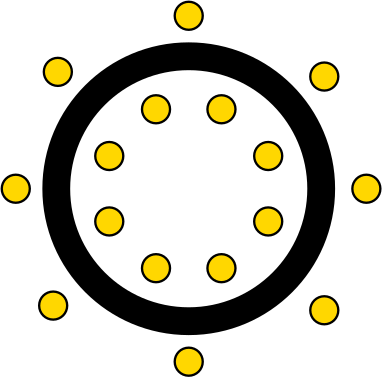

The model below is adjustable, so we will change the number of wires, the current, and the magnetic properties of the cylinder as we explore the fields — and the use of the finite element method!

## Acknowledgements

The installation commands below come from the [FEM on CoLab](https://fem-on-colab.github.io/index.html) project.

This tutorial was adapted from "Electromagnetics example" in [The FEniCSx Tutorial](https://jorgensd.github.io/dolfinx-tutorial/chapter1/fundamentals.html).

Thanks to all of the contributors to these projects!

# Install and Load Packages

These are the commands we use to install FEniCSx, Gmsh, and **multiphenicsx**.

In [1]:
try:
    # Import gmsh library for generating meshes.
    import gmsh
except ImportError:
    # If it is not available, install it.  Then import it.
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

--2022-10-27 16:45:31--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2175 (2.1K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   2.12K  --.-KB/s    in 0s      

2022-10-27 16:45:32 (18.9 MB/s) - ‘/tmp/gmsh-install.sh’ saved [2175/2175]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ac0fe3a/releases/h5py-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ac0fe3a/releases/h5py-install.sh == http* ]]
+ H5PY_INSTALL_SCRIPT_DOWNLOAD=http

In [2]:
try:
    # Import FEniCSx libraries for finite element analysis.
    import dolfinx
except ImportError:
    # If they are not found, install them.  Then import them.
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

--2022-10-27 16:47:20--  https://fem-on-colab.github.io/releases/fenicsx-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3055 (3.0K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   2.98K  --.-KB/s    in 0s      

2022-10-27 16:47:20 (12.3 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [3055/3055]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/f0d2856/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/f0d2856/releases/pybind11-install.sh == http* ]]


In [3]:
try:
    # Import multiphenicsx, mainly for plotting.
    import multiphenicsx
except ImportError:
    # If they are not found, install them.
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@8b97b4e"
    import multiphenicsx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/multiphenics/multiphenicsx.git (to revision 8b97b4e) to /tmp/pip-install-r45jqszp/multiphenicsx_b45e5fceeab74b6a9534a5877ebdb094
  Running command git clone -q https://github.com/multiphenics/multiphenicsx.git /tmp/pip-install-r45jqszp/multiphenicsx_b45e5fceeab74b6a9534a5877ebdb094
  Running command git checkout -q 8b97b4e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for multiphenicsx: filename=multiphenicsx-0.2.dev1-py3-none-any.whl size=42586 sha256=a70f15fc92980737884f631c58bc4da4aa3c9429375abd0d57212c162a76ac3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-vxlhx7im/wheels/a4/44/a9/e578d5b67de6acd8e975bd56c96ee36944a693ee3d7bc91026
Successfully built multiphenicsx


Everything we need should be installed now!

If you "Restart runtime" from the "Runtime" menu, all of your data will be reset, but the packages will remain installed.

Let's load the packages we need, and get started!

In [4]:
# Everything should be installed now.
# Import the rest of what we need.

import dolfinx.fem
import dolfinx.io
import gmsh
import mpi4py.MPI
import numpy as np
import petsc4py.PETSc
import ufl
import multiphenicsx.fem
import multiphenicsx.io

# Inputs

In [89]:
## Adjust this cell to change the geometry:
# Specify sizes of the objects
# and adjust material properties.

# Geometric dimension of the mesh
dim = 2


## Background
# Radius of the entire domain
r_background = 5

# Magnetic permeability (relative) of background medium
mu_background = 1


## Wires
# Radius of individual wires
r_wire = 0.1

# Location of centers of inner and outer rings of wires.
centers_inner = 0.8 
centers_outer = 1.4 

# Number of wires.
N = 5

# Magnetic permeability (relative) of wires.
mu_wire = 2

# Current density in each wire.
J0 = 1.0


## Ring
# Inner and outer radii of ring
ring_inner = 1     
ring_outer = 1.2

ring_inner1 = 2
ring_outer1 = 2.2

# Magnetic permeability (relative) of ring.
mu_ring = 100000

# Concstruct the Model

The physical system is a type of coaxial cable: a ring of $N$ wires carry a current into the page and another ring of $N$ wires carry a return current out of the page.  In between the rings of wires is a cylinder made of iron.

The geometric model is a collection of circles.  The code below draws them all, and then combines them into a single mesh.

In [90]:
# Create a model.
gmsh.initialize()
gmsh.model.add("mesh")

# Define the system: a large disk.
background = gmsh.model.occ.addDisk(0, 0, 0, r_background, r_background)
gmsh.model.occ.synchronize()

# Define geometry for the inside ring.
outer_ring = gmsh.model.occ.addCircle(0, 0, 0, ring_outer)
inner_ring = gmsh.model.occ.addCircle(0, 0, 0, ring_inner)
gmsh.model.occ.addCurveLoop([outer_ring], 5)
gmsh.model.occ.addCurveLoop([inner_ring], 6)
ring = gmsh.model.occ.addPlaneSurface([5, 6])
gmsh.model.occ.synchronize()

# Define geometry for the outside ring.
outer_ring1 = gmsh.model.occ.addCircle(0, 0, 0, ring_outer1)
inner_ring1 = gmsh.model.occ.addCircle(0, 0, 0, ring_inner1)
gmsh.model.occ.addCurveLoop([outer_ring1], 9)
gmsh.model.occ.addCurveLoop([inner_ring1], 10)
ring1 = gmsh.model.occ.addPlaneSurface([9, 10])
gmsh.model.occ.synchronize()

# Create two list of circular disks to represent the wires.
# Define the wires inside the ring.
angles_in = [n * 2*np.pi/N for n in range(N)]
wires_in = [(2,
            gmsh.model.occ.addDisk(centers_inner * np.cos(v),
            centers_inner * np.sin(v), 0, r_wire, r_wire))
            for v in angles_in]

# Define the wires outside the ring.
angles_out = [(n + 0.5) * 2*np.pi/N for n in range(N)]
wires_out = [(2,
            gmsh.model.occ.addDisk(centers_outer * np.cos(v),
            centers_outer * np.sin(v), 0, r_wire, r_wire))
            for v in angles_out]

# Update the model.
gmsh.model.occ.synchronize()

# Resolve the boundaries of the wires and ring in the background domain.
all_surfaces = [(2, ring)]
all_surfaces = [(2, ring1)]
all_surfaces.extend(wires_in)
all_surfaces.extend(wires_out)
whole_domain = gmsh.model.occ.fragment([(2, background)], all_surfaces)

# Update the model.
gmsh.model.occ.synchronize()

# Create physical markers for each object.
# Use the following markers:
# - Vacuum: 0
# - Ring: 1
# - Inner wires: $[2,3,\dots,N+1]$
# - Outer wires: $[N+2,\dots, 2\cdot N+1]$
inner_tag = 2
outer_tag = 2 + N
background_surfaces = []
other_surfaces = []

# Gmsh can compute the mass of objects and the location of their
# centers of mass.  This loop uses these properties to determine
# which object to associate grid points with.
# 
# We will use these tags to define material properties later.
for domain in whole_domain[0]:
    center = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
    mass = gmsh.model.occ.getMass(domain[0], domain[1])

    # Identify the ring by its mass.
    # Check for ring first, because center of mass is same as background.
    if np.isclose(mass, np.pi*(ring_outer**2 - ring_inner**2)):
        gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
        other_surfaces.append(domain)

    elif np.isclose(mass, np.pi*(ring_outer1**2 - ring_inner1**2)):
        gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
        other_surfaces.append(domain)
    
    # Identify the background circle by its center of mass
    elif np.allclose(center, [0, 0, 0]):
        background_surfaces.append(domain[1])

    # Identify the inner wires by their centers of mass.
    elif np.isclose(np.linalg.norm(center), centers_inner):
        gmsh.model.addPhysicalGroup(domain[0], [domain[1]], inner_tag)
        inner_tag +=1
        other_surfaces.append(domain)

    # Identify the outer wires by their center of mass.
    elif np.isclose(np.linalg.norm(center), centers_outer):
        gmsh.model.addPhysicalGroup(domain[0], [domain[1]], outer_tag)
        outer_tag +=1
        other_surfaces.append(domain)

# Add marker for the vacuum.
gmsh.model.addPhysicalGroup(2, background_surfaces, tag=0)

# Create mesh resolution that is fine around the wires and
# make the grid coarse further away from the ring.
gmsh.model.mesh.field.add("Distance", 1)
edges = gmsh.model.getBoundary(other_surfaces, oriented=False)
gmsh.model.mesh.field.setNumbers(1, "EdgesList", [e[1] for e in edges])
gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "IField", 1)
gmsh.model.mesh.field.setNumber(2, "LcMin", r_wire / 2)
gmsh.model.mesh.field.setNumber(2, "LcMax", 5 * r_wire)
gmsh.model.mesh.field.setNumber(2, "DistMin", 2 * r_wire)
gmsh.model.mesh.field.setNumber(2, "DistMax", 4 * r_wire)
gmsh.model.mesh.field.setAsBackgroundMesh(2)
gmsh.option.setNumber("Mesh.Algorithm", 7)

# Create a mesh for this system.
gmsh.model.mesh.generate(dim)

# Bring the mesh into FEniCSx.
mesh, subdomains, boundaries = dolfinx.io.gmshio.model_to_mesh(
    gmsh.model, comm=mpi4py.MPI.COMM_WORLD, rank=0, gdim=2)

gmsh.finalize()

In [91]:
# Plot the entire mesh.
multiphenicsx.io.plot_mesh(mesh)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [92]:
# Plot the subdomains that FEniCSx has identified.
# There should only be one for this model.
multiphenicsx.io.plot_mesh_tags(subdomains)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Finite Element Method

Now it is time to tell FEniCSx the problem we want to solve on this mesh.

You can vary the using the cells above geometry above.  The cell below allows you to specify the boundary conditions along the 4 edges.

In the language of finite elements, an ***essential boundary condition*** specifies the value of the function on a boundary.  A ***natural boundary condtions*** specifies the derivative.

In [93]:
# This loop will assign material properties to each cell in our model.
# In this case, it is the relative magnetic permeability and current density.

# Define a simple function space for properties.
Q = dolfinx.fem.FunctionSpace(mesh, ("DG", 0))

# Get the list of materials.
material_tags = np.unique(subdomains.values)

# Define functions for current density and magnetic permeability.
mu = dolfinx.fem.Function(Q)
J = dolfinx.fem.Function(Q)

# Only some regions carry current. Initialize all current densities to zero.
J.x.array[:] = 0.0

# Now, cycle over all objects and assign material properties. 
for tag in material_tags:
    cells = subdomains.find(tag)
    
    # Set values for magnetic permeability.
    if tag == 0:
        # Vacuum
        mu_ = mu_background
    elif tag == 1:
        # Ring
        mu_ = mu_ring
    else:
        # Wire
        mu_ = mu_wire

    mu.x.array[cells] = np.full_like(cells, mu_, dtype=petsc4py.PETSc.ScalarType)
    
    # Set nonzero current densities.
    if tag in range(2, 2+N):
        J.x.array[cells] = np.full_like(cells, J0, dtype=petsc4py.PETSc.ScalarType)
    elif tag in range(2+N, 2*N + 2):
        J.x.array[cells] = np.full_like(cells, -J0, dtype=petsc4py.PETSc.ScalarType)

In [94]:
## Set up the finite element problem.

# Define trial and test functions.
V = dolfinx.fem.FunctionSpace(mesh, ("Lagrange", 2))

# Define the trial and test functions.
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Create a function to store the solution.
# This is the vector potential.  A_x = A_y = 0.
A_z = dolfinx.fem.Function(V)

# Identify the domain and boundary.
D = mesh.topology.dim
Omega = dolfinx.mesh.locate_entities_boundary(mesh, D-1, lambda x: np.full(x.shape[1], True))
dOmega = dolfinx.fem.locate_dofs_topological(V, D-1, Omega)

# Force the potential to vanish on the boundary.
bc = dolfinx.fem.dirichletbc(petsc4py.PETSc.ScalarType(0), dOmega, V)

# Define the Poisson equation we are trying to solve.
a = (1 / mu) * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = 4 * ufl.pi * J * v * ufl.dx

# Define the problem.
problem = dolfinx.fem.petsc.LinearProblem(a, L, u=A_z, bcs=[bc])

# Solve the problem.
problem.solve()

Coefficient(FunctionSpace(Mesh(VectorElement(Basix element (P, triangle, 1, equispaced, unset, False), 2), 9), Basix element (P, triangle, 2, gll_warped, unset, False)), 34)

In [95]:
# Compute the magnetic field.
W = dolfinx.fem.VectorFunctionSpace(mesh, ("CG", 2))
B = dolfinx.fem.Function(W)
B_expr = dolfinx.fem.Expression(ufl.as_vector((A_z.dx(1), -A_z.dx(0))), W.element.interpolation_points())
B.interpolate(B_expr)

# Results

In [96]:
# Plot the vector potential.
multiphenicsx.io.plot_scalar_field(A_z,"Vector Potential", warp_factor=0.01)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [97]:
# Plot the magnetic field.
multiphenicsx.io.plot_vector_field(B,"Magnetic Field", glyph_factor=0.002)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Experiments

Change the inputs above and run the cells to carry out the following experiments.

## 1. Hit Play

Run the cells above with the default inputs.  (There is a copy of the default inputs in the cell at the bottom of the notebook.)

- Describe the vector potential.
- Describe the magnetic field.



The vector potential looks like a plateau with a bunch of bumps in the top where the wires pass through. Only in the center does the vector potential show up, after the metal ring the vector potential drops off significantly. This makes sense considering it is the curl of the magnetic field. I somewhat expected it to look like a donut where in the center the vector potential would be 0. Then I remembered the example from that article where a ring of magetic field makes a sort of vector potential solenoid. This is similar to that situation if one looks at the magentic field. The magnetic field seems to be greatest on the iron ring between the wires. This makes sense since there will be a field induced in the metal ring which is much greater than the fields surrounding the wires. We can still see the fields surrounding the wires, and those vectors are much smaller than the field in the core.

## 2. Simplify

There is a lot going on in this model.  Let's focus on the field of the wires first.
- Set `N=2`.  This will reduce the simulation to 2 pairs of wires.
- Set `mu_ring = 1`.  This will make the ring have the same permeability as the background — effectively removing it from the system.

Use your knowledge of magnetic fields and Laplace's equation to predict the field pattern.

- What will the vector potential look like?
- What will the field look like around the individual wires?
- Where will the field be the strongest?  The weakest?

Since there will be less wires and there will be no iron core, the magnetic field will probably remain stongest between the wires but be massively reduced in magnitude. A loop will still form similarly to part one, but it may be slightly mishapened due to the geometry only containing two wires


Now run the simulation again.  Inspect the model, the vector potential, and the magnetic field.

- What features are consistent with your predictions?
- What features were surprising?

I was correct in saying that the magnetic field would still be in a ring, but I was wrong that the magnetic field would be greatest in the ring's region. The magnetic field was actually largest around each wire, which makes sense since the magnetic field decreases the further from each wire. The vector potential looks similar, each wire has bumps where the vector potential increases with the increased field.

## 3. Coaxial Cable

Let's use this simulation to model a coaxial cable.  We can increase the number of wires to some large value to simulate to concentric conducting cylinders — one carrying a current into the plane of your monitor and one carrying an equal current out.

- Set `N` to something between 20 and 100.
- Set `mu_ring = 1`.  This will make the ring have the same permeability as the background — effectively removing it from the system.

Use your knowledge of magnetic fields and Laplace's equation to predict the field pattern.

- What will the vector potential look like?
- What will the field look like around the individual wires?
- Where will the field be the strongest?  The weakest?

Since there are more wires, I beleive that once again there will be a field between the wires. This field will probably be stronger near the inside and outside of the loop since there are a lot more wires. The vector potential will probably look more like a plateau this time because the wires are much closer together.

Now run the simulation again.  Inspect the model, the vector potential, and the magnetic field.

- What features are consistent with your predictions?
- What features were surprising?

I was correct that the field between the wires would appear in a ring, but the field wasn't greatest around the edges. It seemed to be largest around each of the wires still, but because there were more wires the field inside the loop became larger. The vector potential looked very similar to my predictions but the plateau had much less steep edges than I expected. The bumps from each one of the wires was still present. As a side note, the graph really didn't want to load when I bumped up the number of wires past about 40. I tried decreasing the wire size but the simulation didn't like that either. It was sitting for about half an hour before I decided that it wasn't going to load the graph.

## 4. Iron Ring

Let's explore the effect of the ring now.  The relative permeability of carbon steel is $\mu \approx 10$ — the default value.  However, the relative permeability of soft iron is much larger: $\mu > 5000$.  Such large values make the plots difficult to interpret, but let's explore the effect of changing $mu$.

- Set `N=2` for 2 pairs of wires.
- Set `mu_ring = 2`.

Use your knowledge of magnetic fields and Laplace's equation to predict the field pattern.

- You simulated a similar system in Experiment #2.  How will the ring affect the field?
- What will the vector potential look like?
- What will the field look like around the individual wires?
- Where will the field be the strongest?  The weakest?

Unlike the part where this experiment was completed without the ring, this time the field between the wires will be much stronger. The iron ring, even having a u value of that small will increase the field strength greatly in the region between the wires. The vector potential will then look much more like a plateau with very steep sides, instead of the few bumps that occured in the part without the ring. Around the individual wires, once again the field will curl around as if the wire had not bee affected.

Now run the simulation again.  Inspect the model, the vector potential, and the magnetic field.

- What features are consistent with your predictions?
- What features were surprising?

I was incorrect about the magnetic field's magnitude in between the wires. The magnetic field did not increase that much because the u value didn't increase that much compared with the surroundings. If it had gone up more the field would probably look a lot more like what I predicted. The vector potential didn't have any significant changes either from the part with no iron ring. 

Repeat the simulation for different values of $\mu$:
- $\mu=5$
- $\mu=10$
- $\mu=100$
- $\mu=5000$

Inspect the model, the vector potential, and the magnetic field.

Summarize the effect of a permeable ring between the wires.

As the ring's permiability went up, the magnetic field in the ring increased greatly. At u = 5, the field inside the loop became visible, unlike the part before where the permiability of the ring had almost no effect on the field. By the upper limit of the u values to test, I had to turn down the glyph and warp factors because the arrows were so large. u for an iron core is around [5000](https://www.engineeringtoolbox.com/permeability-d_1923.html), so this tells us that making an iron toroid with two loops of wire will make very large fields within the toroid.

## 5. Your Choice

Carry out your own experiments with the simulation.  Change the current, the number of wires, the size of the iron ring, the permeability of the wires — or explore your own ideas.

Describe your procedure and your observations.

For the first experiment, I tried to add a second ring to the graph. I was going to add it outside the entire loop, but I couldn't get the field to show at all. The vector potential did show, and that made sense with ampere's law. The circulation around that loop will be proportional to the current enclosed. Since wire with current going in both directions are present, the total current through the loop is 0. This means the circulation around the loop has to be 0. This is what we see approximately. Individually, each wire still creates a small vector potential, but the overall field is 0 through the loop. Next I tried changing the permiability of the outside loop. Even with increased permiability, the vector potential inside the loop was 0 since the circulation around the loop was 0.

# Challenge

## Single Wire

Tinker with the model code.  See if you can create a single large wire.

Compute the vector potential and magnetic field inside and outside the wire.

## Solenoid

You can simulate a cross section of a solenoid by arranging the wires in straight lines instead of concentric rings.  

Try to create a model for an electromagnet with an iron core.

***Replace with your procedure and observations.***

# Reflection and Summary

- What are the major takeaways of this assignment for you?
- What was the most difficult part of this assignment?
- What was the most interesting part of this assignment?
- What questions do you have?

This lab was important because I finally got to see how to use the FEM on magnetic materials. This might actually be able to help me in real life, as I work with HAM radio stuff in my spare time. The other day, when I was trying to design an antenna, I built a trifilar transformer to match impedances between the antenna and the feed line. If I had a tool like this, perhaps I could have modeled a slice of the toroid and the currents passing through it, which could have told me about what type of toroid to buy since they can have different permitivity values. That can affect what kind of losses you see in the transformer, and can help to calculate how much power I need to pass into the transformer to get an output on the antenna that I want. The most difficult part of the assignment was changing up the code to work with a new iron loop for the final part. I tried to get both loops in the simulation, but unfortunately when the second loop was added, the first loop disappeared. I don't know what I did wrong because I'm not very familiar with the functions that are being used and all of the stuff that this program can do. The most interesting part of the assignment was seeing how the permativity value can affect the magnetic field. I now understand where all the engineering behind magnetic materials comes in. I'm wondering after this how I can use vector potential for something useful. Vector potential makes a lot more sense to me after seeing it used so much here, but still I don't see how knowing what it looks like is helpful to me. Can I determine how a particle will act when it is placed in the loop knowing the vector potential? Or is it that the vector potential will be constantly pointing down a wire with this cross section? How does that help me find quantities that are useful to me?

## Default Inputs

In [98]:
## Adjust this cell to change the geometry:
# Specify sizes of the objects
# and adjust material properties.

# Geometric dimension of the mesh
dim = 2


## Background
# Radius of the entire domain
r_background = 5

# Magnetic permeability (relative) of background medium
mu_background = 1


## Wires
# Radius of individual wires
r_wire = 0.1

# Location of centers of inner and outer rings of wires.
centers_inner = 0.8 
centers_outer = 1.4 

# Number of wires.
N = 6

# Magnetic permeability (relative) of wires.
mu_wire = 1

# Current density in each wire.
J0 = 1.0


## Ring
# Inner and outer radii of ring
ring_inner = 1     
ring_outer = 1.2

# Magnetic permeability (relative) of ring.
mu_ring = 10